# Initial Setup

In [1]:
!pip install numpy matplotlib

We use **Fast Downward**, a standard classical STRIPS planner commonly adopted
in academic courses on automated planning.  
Since Colab does not include any planner by default, we install the official
version from the public GitHub repository and build it locally.

This installation is only required to *execute* the PDDL models defined in the
next sections.

In [2]:
# Install system dependencies
!sudo apt-get -y install cmake g++ python3-dev

# Clone FastDownward
!git clone https://github.com/aibasel/downward.git fastdownward

# Build FastDownward
%cd fastdownward
!./build.py

# Return to working directory
%cd /content

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
g++ is already the newest version (4:11.2.0-1ubuntu1).
g++ set to manually installed.
cmake is already the newest version (3.22.1-1ubuntu1.22.04.2).
The following additional packages will be installed:
  javascript-common libjs-sphinxdoc libjs-underscore python3.10-dev
Suggested packages:
  apache2 | lighttpd | httpd
The following NEW packages will be installed:
  javascript-common libjs-sphinxdoc libjs-underscore python3-dev
  python3.10-dev
0 upgraded, 5 newly installed, 0 to remove and 41 not upgraded.
Need to get 796 kB of archives.
After this operation, 1,257 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 javascript-common all 11+nmu1 [5,936 B]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libjs-underscore all 1.13.2~dfsg-2 [118 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libjs-sphinxdoc all 4.3.2-1 [139 kB]
I

In [3]:
!./fastdownward/fast-downward.py --help #test

usage: fast-downward.py [-h] [-v] [--show-aliases] [--run-all] [--translate]
                        [--search]
                        [--translate-time-limit TRANSLATE_TIME_LIMIT]
                        [--translate-memory-limit TRANSLATE_MEMORY_LIMIT]
                        [--search-time-limit SEARCH_TIME_LIMIT]
                        [--search-memory-limit SEARCH_MEMORY_LIMIT]
                        [--validate-time-limit VALIDATE_TIME_LIMIT]
                        [--validate-memory-limit VALIDATE_MEMORY_LIMIT]
                        [--overall-time-limit OVERALL_TIME_LIMIT]
                        [--overall-memory-limit OVERALL_MEMORY_LIMIT]
                        [--alias ALIAS] [--build BUILD] [--debug] [--validate]
                        [--log-level {debug,info,warning}] [--plan-file FILE]
                        [--sas-file FILE] [--keep-sas-file] [--portfolio FILE]
                        [--portfolio-bound VALUE] [--portfolio-single-plan]
                        

In [4]:
import os
os.getcwd() #test

'/content'

# Benchmark Maps Download & Setup

This section downloads official grid maps from the MovingAI pathfinding benchmark repository and stores them under benchmarks/maps/. These files will be used for A* search, PDDL modeling, and experimental evaluation.

In [5]:
import os
os.makedirs("benchmarks/maps", exist_ok=True)


In [6]:
!wget -O benchmarks/maps/benchmarks_bitbucket.zip \
https://bitbucket.org/shortestpathlab/benchmarks/get/master.zip

--2025-12-02 21:19:00--  https://bitbucket.org/shortestpathlab/benchmarks/get/master.zip
Resolving bitbucket.org (bitbucket.org)... 13.200.41.136, 13.200.41.134, 13.200.41.135, ...
Connecting to bitbucket.org (bitbucket.org)|13.200.41.136|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 508283420 (485M) [application/zip]
Saving to: ‘benchmarks/maps/benchmarks_bitbucket.zip’

benchmarks/maps/ben 100%[===================>] 484.74M  17.1MB/s    in 30s     

2025-12-02 21:19:31 (16.3 MB/s) - ‘benchmarks/maps/benchmarks_bitbucket.zip’ saved [508283420/508283420]



In [7]:
import zipfile

zip_path = "benchmarks/maps/benchmarks_bitbucket.zip"

with zipfile.ZipFile(zip_path, "r") as z:
    z.extractall("benchmarks/maps")

print("Extraction complete.")

Extraction complete.


In [8]:
!ls benchmarks/maps

benchmarks_bitbucket.zip  shortestpathlab-benchmarks-fe6351b0700a


In [9]:
import shutil

root = "benchmarks/maps"
folder = "shortestpathlab-benchmarks-fe6351b0700a"   # folder name
source_dir = f"{root}/{folder}/grid-maps"

datasets = ["gppc-2013", "gppc-2014", "iron-harvest", "local", "movingai"]

for d in datasets:
    src = f"{source_dir}/{d}"
    dst = f"{root}/{d}"
    if os.path.exists(src):
        shutil.move(src, dst)
        print(f"Moved: {d}")
    else:
        print(f"NOT FOUND: {d}")

Moved: gppc-2013
Moved: gppc-2014
Moved: iron-harvest
Moved: local
Moved: movingai


In [10]:
!rm -rf benchmarks/maps/shortestpathlab-benchmarks-fe6351b0700a

In [11]:
!rm benchmarks/maps/benchmarks_bitbucket.zip

# Gridword Environment Implementation

Before implementing A* or generating PDDL problems, we need a structured internal
representation of the environment.  
The benchmark maps are provided in the standard **.map** format used in the MovingAI
and GPPC competitions, where each character encodes whether a cell is free or blocked.

The `GridWorld` class loads a `.map` file and provides:
- the **grid matrix** (height × width),
- identification of **traversable cells** and **obstacles**,
- optional **start (S)** and **goal (G)** markers,
- consistent generation of **4/8-connected neighbors**,
- utility functions for checking bounds and obstacles.

This representation is used in *two* parts of the homework:

1. **A\***  
   The A* search algorithm relies on `GridWorld` to explore valid neighbors, compute costs,
   and determine when the goal has been reached.

2. **PDDL Planning**  
   When generating PDDL domain and problem files, the grid structure is used to:
   - define predicates (e.g., `adjacent`),
   - instantiate actions (e.g., `move`),
   - specify the initial and goal state based on grid coordinates.

GridWorld is therefore a shared foundation for both classical search and planning.

In [12]:
class GridWorld:
    """
    GridWorld loads a .map file and creates a grid representation.

    Supports:
      - 4-connected (default)
      - 8-connected (diagonal moves enabled with connectivity=8)

    This class is used both for A* search and for generating PDDL problems.
    """

    WALL_TILES = {'@', 'T', '#'}

    def __init__(self, map_path, start=None, goal=None, connectivity=4):

        #:param connectivity: 4 or 8 (movement directions)

        if connectivity not in (4, 8):
            raise ValueError("Connectivity must be either 4 or 8.")

        self.connectivity = connectivity

        if not os.path.exists(map_path):
            raise FileNotFoundError(f"Map file not found: {map_path}")

        self.map_path = map_path
        self.grid = []
        self.width = None
        self.height = None

        self.start = None
        self.goal = None

        self._load_map()

        # override S/G if manually provided
        if self.start is None and start is not None:
            self._check_traversable(start)
            self.start = start

        if self.goal is None and goal is not None:
            self._check_traversable(goal)
            self.goal = goal


    # LOAD MAP

    def _load_map(self):
        #Parse .map files in standard MovingAI / GPPC format

        with open(self.map_path, "r") as f:
            lines = [line.rstrip("\n") for line in f]

        # find "map" keyword
        try:
            map_index = next(i for i, line in enumerate(lines)
                             if line.strip().lower() == "map")
        except StopIteration:
            raise ValueError(f"Invalid .map file (missing 'map' line): {self.map_path}")

        header = lines[:map_index]
        grid_lines = lines[map_index+1:]

        # optional declared width/height
        declared_w = None
        declared_h = None

        for line in header:
            parts = line.split()
            if len(parts) == 2:
                if parts[0].lower() == "width":
                    declared_w = int(parts[1])
                if parts[0].lower() == "height":
                    declared_h = int(parts[1])

        # build matrix
        self.height = len(grid_lines)
        if self.height == 0:
            raise ValueError(f"No grid rows found in {self.map_path}")

        self.width = len(grid_lines[0])

        for y, row_str in enumerate(grid_lines):
            if len(row_str) != self.width:
                raise ValueError(
                    f"Inconsistent row length in {self.map_path}, "
                    f"row {y}: expected {self.width}, got {len(row_str)}"
                )

            row = []
            for x, ch in enumerate(row_str):

                # Detect start/goal markers
                if ch == 'S':
                    self.start = (x, y)
                elif ch == 'G':
                    self.goal = (x, y)

                row.append(ch)

            self.grid.append(row)

        # check dimensions match header
        if declared_w not in (None, self.width):
            raise ValueError(f"Declared width {declared_w} != parsed {self.width}")

        if declared_h not in (None, self.height):
            raise ValueError(f"Declared height {declared_h} != parsed {self.height}")


    # BASIC CHECKS
    def _check_traversable(self, pos):
        #Ensure a position is valid and not a wall
        if not self.in_bounds(pos):
            raise ValueError(f"Position {pos} is outside the grid.")
        if self.is_wall(pos):
            raise ValueError(f"Position {pos} is a wall (invalid start/goal).")

    def in_bounds(self, pos):
        #Return True if inside grid
        x, y = pos
        return 0 <= x < self.width and 0 <= y < self.height

    def is_wall(self, pos):
        #Return True if the tile is an obstacle
        x, y = pos
        return self.grid[y][x] in self.WALL_TILES


    # NEIGHBORS (4 OR 8 CONNECTED)
    def neighbors(self, pos):
        """
        Compute neighbors based on connectivity:
        - 4-connected: cardinal moves
        - 8-connected: cardinal + diagonal moves
        """
        x, y = pos

        # cardinal moves
        directions = [(1,0), (-1,0), (0,1), (0,-1)]

        # add diagonals
        if self.connectivity == 8:
            directions += [(1,1), (1,-1), (-1,1), (-1,-1)]

        result = []
        for dx, dy in directions:
            nx, ny = x + dx, y + dy
            new_pos = (nx, ny)

            if self.in_bounds(new_pos) and not self.is_wall(new_pos):
                result.append(new_pos)

        return result


    # COST FUNCTION
    def cost(self, from_pos, to_pos):
        """
        Cost model:
        - straight move: 1.0
        - diagonal move: sqrt(2) (only if connectivity == 8)
        """
        dx = abs(from_pos[0] - to_pos[0])
        dy = abs(from_pos[1] - to_pos[1])

        if dx == 1 and dy == 1:  # diagonal
            return (2 ** 0.5) if self.connectivity == 8 else 1.0

        return 1.0

    # UTILITY
    def tile_at(self, pos):
        x, y = pos
        return self.grid[y][x]

    def __str__(self):
        return "\n".join("".join(row) for row in self.grid)

In [13]:
#Test GridWorld

import glob

# Find some map files
maps = glob.glob("benchmarks/maps/**/*.map", recursive=True)
print("Found maps:", len(maps))

# Show first few paths
print("Example maps:", maps[:3])

# Pick the first map to test
test_map = maps[0]
print("\nTesting map:", test_map)

# Load it
gw = GridWorld(test_map)

# Print basic info
print("Grid size:", gw.width, "x", gw.height)

print("Tile at (0,0):", gw.tile_at((0,0)))
print("Neighbors of (0,0):", gw.neighbors((0,0)))

# Check if map contains S or G
print("Start:", gw.start)
print("Goal:", gw.goal)

Found maps: 1236
Example maps: ['benchmarks/maps/local/test_s3_64.map', 'benchmarks/maps/local/mts0.map', 'benchmarks/maps/local/test_s3.map']

Testing map: benchmarks/maps/local/test_s3_64.map
Grid size: 64 x 64
Tile at (0,0): @
Neighbors of (0,0): []
Start: None
Goal: None


In [14]:
# Problem wrapper for GridWorld (generic search interface)

class GridWorldProblem:
    """
    Generic search problem interface for GridWorld.
    It exposes:
      - initial_state
      - goal_state
      - is_goal(s)
      - actions(s)
      - child_node(s, a)
      - cost(s, s2)
    """

    def __init__(self, gridworld, start=None, goal=None):
        self.gw = gridworld
        self.initial_state = start if start is not None else gridworld.start
        self.goal_state    = goal  if goal  is not None else gridworld.goal

        if self.initial_state is None or self.goal_state is None:
            raise ValueError("Start or goal not defined.")

    def is_goal(self, state):
        return state == self.goal_state

    def actions(self, state):
        # In a grid, actions are simply the neighbors
        return self.gw.neighbors(state)

    def child_node(self, state, action):
        # action = next state
        return action

    def cost(self, state1, state2):
        return self.gw.cost(state1, state2)

# A* search

In this section we implement **A\*** with duplicate elimination and no re-opening, a best-first search algorithm that finds the optimal path from a start position to a goal in a gridworld.  
A\* maintains for each explored node:

- **g(n)**: the cost to reach *n* from the start  
- **h(n)**: a heuristic estimate of the cost from *n* to the goal  
- **f(n) = g(n) + h(n)**: the evaluation function used to select which node to expand next  

We use the **Manhattan distance** as heuristic, which is admissible and consistent in a 4-connected grid.  
A\* uses a **priority queue (min-heap)** to always expand the node with the lowest f-value and reconstructs the final path by backtracking from the goal.

The following cell contains the full implementation of the A\* algorithm.

In [15]:
# A* (Duplicate elimination + No re-opening + Metrics)

import heapq

class AStar:
    def __init__(self, problem, heuristic=None):
        """
        Modular A* implementation.

        problem must define:
            - initial_state
            - goal_state
            - actions(state)
            - child_node(state, action)
            - cost(s1, s2)
            - is_goal(state)

        heuristic: function h(state, goal_state)
                   If None → h(s) = 0 (Uniform Cost Search)
        """
        self.problem = problem
        self.h = heuristic if heuristic else (lambda s, g: 0)

        # METRICS
        self.expanded = 0
        self.generated = 0
        self.max_frontier_size = 0
        self.max_explored_size = 0

        # Track branching factor values (children count per expanded node)
        self.bf_values = []

    def search(self):
        start = self.problem.initial_state
        goal  = self.problem.goal_state

        frontier = []
        heapq.heappush(frontier, (0, start))
        frontier_dict = {start: 0}

        explored = set()

        parent = {start: None}
        g_score = {start: 0}

        while frontier:
            self.max_frontier_size = max(self.max_frontier_size, len(frontier))

            _, current = heapq.heappop(frontier)
            if current in explored:
                continue

            explored.add(current)
            self.expanded += 1
            self.max_explored_size = max(self.max_explored_size, len(explored))

            if self.problem.is_goal(current):
                return self.reconstruct_path(current, parent)

            # BRANCHING FACTOR TRACKING
            actions = self.problem.actions(current)
            self.bf_values.append(len(actions))


            for action in actions:
                self.generated += 1
                neighbor = self.problem.child_node(current, action)

                if neighbor in explored:
                    continue

                tentative_g = g_score[current] + self.problem.cost(current, neighbor)

                if neighbor not in frontier_dict or tentative_g < g_score.get(neighbor, float('inf')):
                    parent[neighbor] = current
                    g_score[neighbor] = tentative_g
                    f = tentative_g + self.h(neighbor, goal)

                    heapq.heappush(frontier, (f, neighbor))
                    frontier_dict[neighbor] = f

        return None  # frontier empty → failure

    def reconstruct_path(self, state, parent):
        path = []
        while state is not None:
            path.append(state)
            state = parent[state]
        return list(reversed(path))

    # branching factor summary
    def branching_stats(self):
        if not self.bf_values:
            return (0, 0, 0)
        return (
            min(self.bf_values),
            max(self.bf_values),
            sum(self.bf_values) / len(self.bf_values)
        )

In [16]:
# Heuristics

def manhattan(a, b):
    return abs(a[0] - b[0]) + abs(a[1] - b[1])

def euclidean(a,b):
    dx = a[0] - b[0]
    dy = a[1] - b[1]
    return (dx*dx + dy*dy)**0.5

In [17]:
from collections import deque

def bfs_farthest(gw, start):
    #Returns (farthest_node, distance)
    visited = set([start])
    q = deque([(start, 0)])
    farthest = (start, 0)

    while q:
        node, dist = q.popleft()
        farthest = (node, dist)

        for nb in gw.neighbors(node):
            if nb not in visited:
                visited.add(nb)
                q.append((nb, dist + 1))

    return farthest  # (node, distance)


def pick_farthest_pair(gw):

    #Selects (start, goal) as the two farthest nodes in the same connected component
    #using double-BFS (graph diameter approximation)


    # 1. pick any free cell
    for y in range(gw.height):
        for x in range(gw.width):
            if not gw.is_wall((x,y)):
                first = (x,y)
                break
        else:
            continue
        break

    # 2. BFS #1 → farthest node A
    A, _ = bfs_farthest(gw, first)

    # 3. BFS #2 → farthest node from A → B
    B, _ = bfs_farthest(gw, A)

    return A, B

In [18]:
import pandas as pd
import time

def run_astar_experiment(map_paths, connectivity=4, heuristic=manhattan):
    """
    Run A* experiments on a list of maps.

    Parameters:
    - map_paths: list of .map files
    - connectivity: 4 or 8 (movement model)
    - heuristic: heuristic function (e.g., manhattan or euclidean)

    Returns:
    - DataFrame with performance metrics
    """
    results = []

    for mp in map_paths:

        # Load gridworld with selected connectivity (4 or 8)
        gw = GridWorld(mp, connectivity=connectivity)

        # Choose start and goal (fallback if S/G not present)
        if gw.start and gw.goal:
            start, goal = gw.start, gw.goal
        else:
            start, goal = pick_farthest_pair(gw)

        # Define problem
        prob = GridWorldProblem(gw, start, goal)

        # Create A* planner with selected heuristic
        planner = AStar(prob, heuristic=heuristic)

        # Run A*
        t0 = time.time()
        path = planner.search()
        t1 = time.time()

        # branching factor metrics
        bf_min, bf_max, bf_avg = planner.branching_stats()

        # Collect metrics
        results.append({
            "map": mp.split("/")[-1],
            "connectivity": connectivity,
            "heuristic": heuristic.__name__,
            "size": f"{gw.width}x{gw.height}",
            "found": path is not None,
            "path_length": len(path) if path else None,
            "time_sec": round(t1 - t0, 5),

            # CORE METRICS
            "expanded": planner.expanded,
            "generated": planner.generated,

            # NEW detailed branching factor metrics
            "bf_min": bf_min,
            "bf_max": bf_max,
            "bf_avg": round(bf_avg, 3) if bf_avg else None,

            "max_frontier": planner.max_frontier_size,
            "max_explored": planner.max_explored_size
        })

    return pd.DataFrame(results)

utils for experiments


In [19]:
# Plotting function

import numpy as np
import matplotlib.pyplot as plt

def plot_gridworld_path(gw, path=None, start=None, goal=None,
                        figsize=(8,6), title=None):
    """
    Visualize a GridWorld map and an optional A* path.

    - Obstacles are shown in black.
    - Free cells are white.
    - Path is drawn in blue.
    - Start: green dot
    - Goal: red 'X'
    """

    h, w = gw.height, gw.width
    img = np.zeros((h, w))

    # Build binary matrix of obstacles
    for y in range(h):
        for x in range(w):
            img[y, x] = 1 if gw.is_wall((x,y)) else 0

    plt.figure(figsize=figsize)
    plt.imshow(img, cmap="gray_r", origin="upper")

    # Draw path if available
    if path:
        xs = [p[0] for p in path]
        ys = [p[1] for p in path]
        plt.plot(xs, ys, color="blue", linewidth=2, label="path")

    # Draw start and goal
    if start:
        plt.scatter(start[0], start[1], color="green", s=80, label="start")

    if goal:
        plt.scatter(goal[0], goal[1], color="red", s=80, marker="x", label="goal")

    # Optional title
    if title:
        plt.title(title)

    # Legend
    plt.legend(loc="upper right")

    # Fix orientation (y increases downward)
    plt.gca().invert_yaxis()

    plt.show()

In [20]:
# Combined print + visualize paths

def visualize_paths_for_maps(map_paths, connectivity=4, heuristic=manhattan, max_steps=10):
    """
    Visualize A* paths for a list of maps.

    Parameters:
    - map_paths: list of .map files
    - connectivity: 4 or 8 (movement model)
    - heuristic: heuristic function (manhattan or euclidean)
    - max_steps: number of initial/final steps to print
    """

    for i, mp in enumerate(map_paths):
        print("="*100)
        print(f"[{i}] MAP: {mp}")
        print(f" -> Connectivity: {connectivity}-connected")
        print(f" -> Heuristic: {heuristic.__name__}")

        # Load grid with selected movement model
        gw = GridWorld(mp, connectivity=connectivity)

        # Start & goal (fallback if no S/G found)
        if gw.start and gw.goal:
            start, goal = gw.start, gw.goal
        else:
            start, goal = pick_farthest_pair(gw)

        # Define gridworld problem
        prob = GridWorldProblem(gw, start, goal)

        # Run A*
        planner = AStar(prob, heuristic=heuristic)
        path = planner.search()

        print(f"Grid size: {gw.width} x {gw.height}")
        print(f"Start: {start}, Goal: {goal}")

        if path is None:
            print(" NO PATH FOUND\n")
            continue

        print(f"  Path found! Length: {len(path)}")
        print("   First steps:", path[:max_steps])
        print("   Last steps:", path[-max_steps:])

        # Plot with title
        title = f"{mp.split('/')[-1]} | {connectivity}-connected | {heuristic.__name__}"
        plot_gridworld_path(gw, path=path, start=start, goal=goal, title=title)

        print()

Experiments

In [21]:
import glob

# Scan map categories (recursive to capture subfolders)
local_maps  = glob.glob("benchmarks/maps/local/**/*.map", recursive=True)
gppc13_maps = glob.glob("benchmarks/maps/gppc-2013/**/*.map", recursive=True)
gppc14_maps = glob.glob("benchmarks/maps/gppc-2014/**/*.map", recursive=True)

# Iron Harvest does not exist in this dataset, but we keep the code for completeness
iron_maps = glob.glob("benchmarks/maps/iron-harvest/**/*.map", recursive=True)

print("LOCAL MAPS FOUND:", len(local_maps))
print(local_maps[:10], "\n")

print("GPPC-2013 MAPS FOUND:", len(gppc13_maps))
print(gppc13_maps[:10], "\n")

print("GPPC-2014 MAPS FOUND:", len(gppc14_maps))
print(gppc14_maps[:10], "\n")

if len(iron_maps) == 0:
    print("IRON-HARVEST MAPS FOUND: 0 (this dataset is NOT included in the Bitbucket benchmark)\n")
else:
    print("IRON-HARVEST MAPS FOUND:", len(iron_maps))
    print(iron_maps[:10], "\n")

LOCAL MAPS FOUND: 60
['benchmarks/maps/local/test_s3_64.map', 'benchmarks/maps/local/mts0.map', 'benchmarks/maps/local/test_s3.map', 'benchmarks/maps/local/test_s4_64.map', 'benchmarks/maps/local/LINE.map', 'benchmarks/maps/local/small.map', 'benchmarks/maps/local/adaptive-depth-11.map', 'benchmarks/maps/local/smalltrap_4.map', 'benchmarks/maps/local/dia10x10.map', 'benchmarks/maps/local/adaptive-depth-8.map'] 

GPPC-2013 MAPS FOUND: 132
['benchmarks/maps/gppc-2013/lt_darktown.map', 'benchmarks/maps/gppc-2013/lt_warehouse_n.map', 'benchmarks/maps/gppc-2013/orz201d.map', 'benchmarks/maps/gppc-2013/lt_gallowscourtyard.map', 'benchmarks/maps/gppc-2013/lt_gallowstemplar_f.map', 'benchmarks/maps/gppc-2013/lt_0_lowtown_docks.map', 'benchmarks/maps/gppc-2013/room-400-40.map', 'benchmarks/maps/gppc-2013/w_sundermount.map', 'benchmarks/maps/gppc-2013/orz105d.map', 'benchmarks/maps/gppc-2013/lt_ruinedhouse_n.map'] 

GPPC-2014 MAPS FOUND: 132
['benchmarks/maps/gppc-2014/lt_darktown.map', 'benchma

In [22]:
import os


#  AUTOMATIC SELECTION OF EXPERIMENT MAPS


# Easy maps (local)
easy_candidates = [
    "demo.map",
    "dia10x10.map",
    "adaptive-depth-1.map"
]

easy_maps = []
for name in easy_candidates:
    matches = glob.glob(f"benchmarks/maps/local/**/{name}", recursive=True)
    if matches:
        easy_maps.append(matches[0])

# Harder GPPC-2013 maps
hard_candidates = [
    "Aurora.map",
    "Brushfire.map",
    "room-1100-110.map"
]

hard_maps = []
for name in hard_candidates:
    matches = glob.glob(f"benchmarks/maps/gppc-2013/**/{name}", recursive=True)
    if matches:
        hard_maps.append(matches[0])

# Combine final experiment set
experiment_maps = easy_maps + hard_maps


#  PRINT RESULTS

print("Selected EASY maps:")
for m in easy_maps:
    print(" -", m)

print("\nSelected HARD maps:")
for m in hard_maps:
    print(" -", m)

print("\nFINAL EXPERIMENT SET:")
for m in experiment_maps:
    print(" -", m)

Selected EASY maps:
 - benchmarks/maps/local/demo.map
 - benchmarks/maps/local/dia10x10.map
 - benchmarks/maps/local/adaptive-depth-1.map

Selected HARD maps:
 - benchmarks/maps/gppc-2013/Aurora.map
 - benchmarks/maps/gppc-2013/Brushfire.map
 - benchmarks/maps/gppc-2013/room-1100-110.map

FINAL EXPERIMENT SET:
 - benchmarks/maps/local/demo.map
 - benchmarks/maps/local/dia10x10.map
 - benchmarks/maps/local/adaptive-depth-1.map
 - benchmarks/maps/gppc-2013/Aurora.map
 - benchmarks/maps/gppc-2013/Brushfire.map
 - benchmarks/maps/gppc-2013/room-1100-110.map


EXPERIMENT: A* on two categories of benchmark maps

  - EASY MAPS  →   4-connected movement, Manhattan heuristic
  - HARD MAPS  →   8-connected movement, Euclidean heuristic

This follows the homework instructions requiring:
   "A* with one or more suitable heuristics"

Reasoning:
  - Manhattan is admissible and consistent for 4-connected grids.
  - Euclidean distance is the natural admissible heuristic when
    diagonal moves are allowed (8-connected grids).

 This setup also highlights the effect of:
   * different movement models (grid topology)
   * different heuristics
   * map complexity

The final result is a combined DataFrame containing all metrics:
  - path found?
  - path length
  - runtime
  - expanded nodes
  - generated nodes
  - branching factor
  - frontier / explored set sizes

This DataFrame will be used in the report for analysis.


In [23]:
print("Running A* on EASY maps (4-connected + Manhattan)...\n")

df_easy = run_astar_experiment(
    easy_maps,
    connectivity=4,        # movement model: 4 neighbors (no diagonals)
    heuristic=manhattan    # admissible heuristic for this model
)

print("Running A* on HARD maps (8-connected + Euclidean)...\n")

df_hard = run_astar_experiment(
    hard_maps,
    connectivity=8,        # movement model: 8 neighbors (diagonals allowed)
    heuristic=euclidean    # admissible heuristic for diagonal movement
)

# Combine the two experiment groups into a single result table

df_exp = pd.concat([df_easy, df_hard], ignore_index=True)

print("=== FINAL A* EXPERIMENT RESULTS ===")

# Save CSV locally
df_exp.to_csv("A*_results.csv", index=False)

# Download CSV (Colab)
from google.colab import files
files.download("A*_results.csv")

df_exp

Running A* on EASY maps (4-connected + Manhattan)...

Running A* on HARD maps (8-connected + Euclidean)...

=== FINAL A* EXPERIMENT RESULTS ===


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,map,connectivity,heuristic,size,found,path_length,time_sec,expanded,generated,bf_min,bf_max,bf_avg,max_frontier,max_explored
0,demo.map,4,manhattan,25x11,True,35,0.00049,35,99,2,3,2.912,32,35
1,dia10x10.map,4,manhattan,10x10,True,19,0.00018,19,50,2,3,2.778,16,19
2,adaptive-depth-1.map,4,manhattan,100x100,True,198,0.06744,5237,19626,1,4,3.748,319,5237
3,Aurora.map,8,euclidean,1024x768,True,166,0.00959,565,3296,2,8,5.844,20,565
4,Brushfire.map,8,euclidean,512x512,True,750,0.58875,48125,372984,1,8,7.750,1192,48125
5,room-1100-110.map,8,euclidean,1100x1100,True,220,0.16213,13572,107602,3,8,7.929,1152,13572


Visualizing A* paths for selected maps...

=== EASY MAPS VISUALIZATION (4-connected + Manhattan) ===

[0] MAP: benchmarks/maps/local/demo.map
 -> Connectivity: 4-connected
 -> Heuristic: manhattan
Grid size: 25 x 11
Start: (24, 10), Goal: (0, 0)
  Path found! Length: 35
   First steps: [(24, 10), (23, 10), (22, 10), (21, 10), (20, 10), (19, 10), (18, 10), (17, 10), (16, 10), (15, 10)]
   Last steps: [(0, 9), (0, 8), (0, 7), (0, 6), (0, 5), (0, 4), (0, 3), (0, 2), (0, 1), (0, 0)]


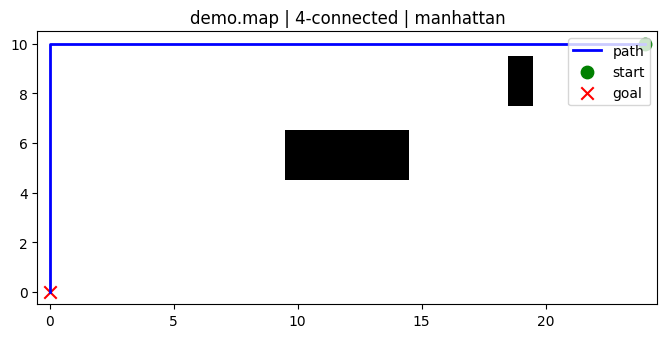


[1] MAP: benchmarks/maps/local/dia10x10.map
 -> Connectivity: 4-connected
 -> Heuristic: manhattan
Grid size: 10 x 10
Start: (9, 9), Goal: (0, 0)
  Path found! Length: 19
   First steps: [(9, 9), (8, 9), (7, 9), (6, 9), (5, 9), (4, 9), (3, 9), (2, 9), (1, 9), (0, 9)]
   Last steps: [(0, 9), (0, 8), (0, 7), (0, 6), (0, 5), (0, 4), (0, 3), (0, 2), (0, 1), (0, 0)]


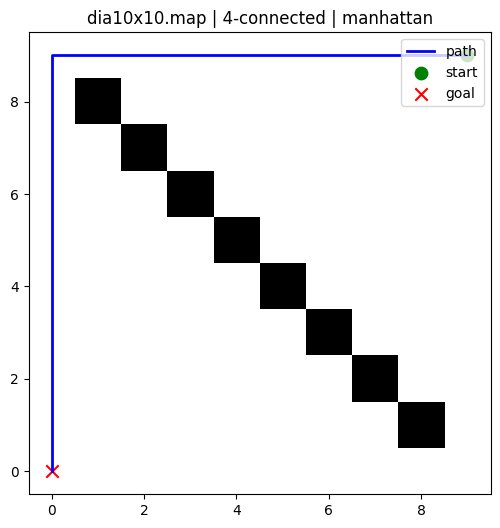


[2] MAP: benchmarks/maps/local/adaptive-depth-1.map
 -> Connectivity: 4-connected
 -> Heuristic: manhattan
Grid size: 100 x 100
Start: (98, 98), Goal: (78, 33)
  Path found! Length: 198
   First steps: [(98, 98), (97, 98), (96, 98), (95, 98), (94, 98), (93, 98), (92, 98), (91, 98), (91, 97), (91, 96)]
   Last steps: [(78, 24), (78, 25), (78, 26), (78, 27), (78, 28), (78, 29), (78, 30), (78, 31), (78, 32), (78, 33)]


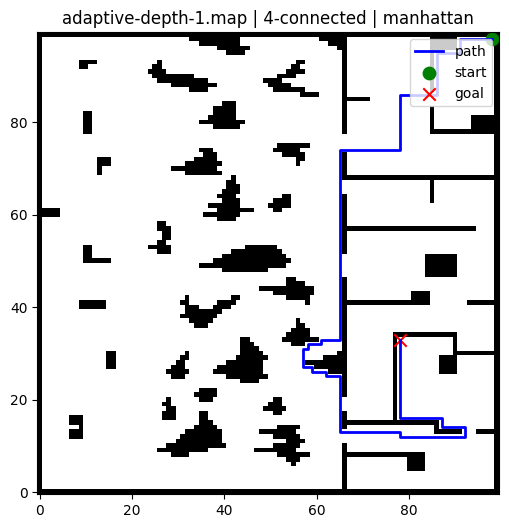



=== HARD MAPS VISUALIZATION (8-connected + Euclidean) ===

[0] MAP: benchmarks/maps/gppc-2013/Aurora.map
 -> Connectivity: 8-connected
 -> Heuristic: euclidean
Grid size: 1024 x 768
Start: (394, 76), Goal: (558, 6)
  Path found! Length: 166
   First steps: [(394, 76), (395, 75), (396, 75), (397, 75), (398, 75), (399, 75), (400, 75), (401, 75), (402, 75), (403, 75)]
   Last steps: [(550, 3), (551, 3), (552, 3), (553, 3), (554, 2), (555, 3), (556, 3), (557, 4), (558, 5), (558, 6)]


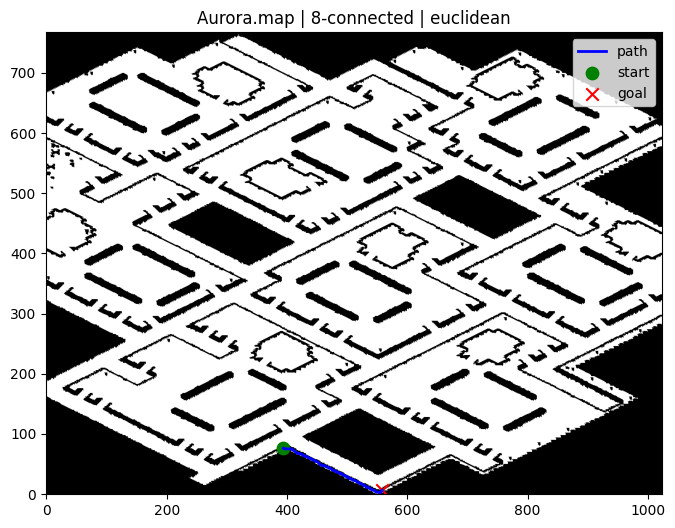


[1] MAP: benchmarks/maps/gppc-2013/Brushfire.map
 -> Connectivity: 8-connected
 -> Heuristic: euclidean
Grid size: 512 x 512
Start: (491, 507), Goal: (112, 507)
  Path found! Length: 750
   First steps: [(491, 507), (490, 506), (490, 505), (489, 504), (488, 503), (488, 502), (488, 501), (488, 500), (488, 499), (488, 498)]
   Last steps: [(108, 498), (108, 499), (109, 500), (109, 501), (110, 502), (110, 503), (111, 504), (111, 505), (111, 506), (112, 507)]


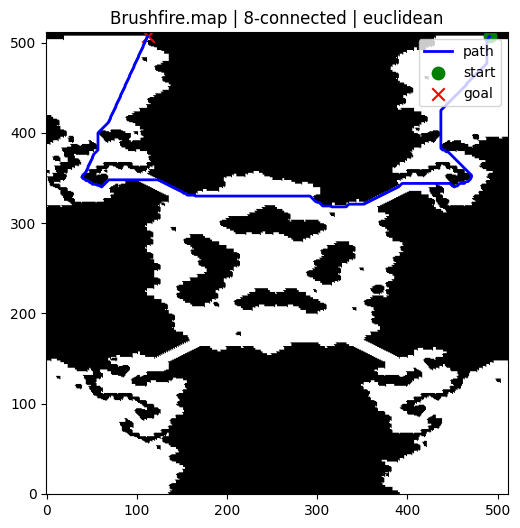


[2] MAP: benchmarks/maps/gppc-2013/room-1100-110.map
 -> Connectivity: 8-connected
 -> Heuristic: euclidean
Grid size: 1100 x 1100
Start: (109, 219), Goal: (7, 0)
  Path found! Length: 220
   First steps: [(109, 219), (108, 218), (107, 217), (106, 216), (105, 215), (104, 214), (104, 213), (103, 212), (103, 211), (103, 210)]
   Last steps: [(11, 9), (11, 8), (10, 7), (10, 6), (9, 5), (9, 4), (8, 3), (8, 2), (7, 1), (7, 0)]


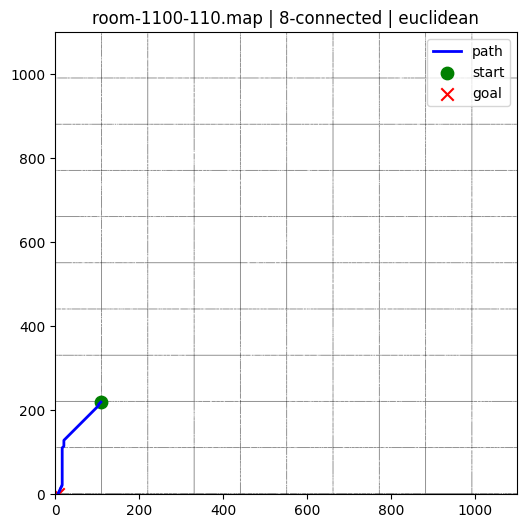

In [24]:
print("Visualizing A* paths for selected maps...\n")

# EASY maps → 4-connected + Manhattan
print("=== EASY MAPS VISUALIZATION (4-connected + Manhattan) ===\n")
visualize_paths_for_maps(
    easy_maps,
    connectivity=4,
    heuristic=manhattan
)

# HARD maps → 8-connected + Euclidean
print("\n=== HARD MAPS VISUALIZATION (8-connected + Euclidean) ===\n")
visualize_paths_for_maps(
    hard_maps,
    connectivity=8,
    heuristic=euclidean
)

# PDDL modeling for Grid Pathfinding

In this section we introduce a PDDL encoding of the same GridWorld used for A*.  
The goal is to express grid navigation as a classical planning problem and solve it
with **Fast Downward**.

We proceed in three steps:

1. Domain Definition

    We create a simple PDDL domain that models:
    - each cell as an object,
    - a predicate describing the agent’s current position,
    - a predicate describing valid transitions between cells,
    - one `move` action that allows the agent to move between adjacent free cells.

2. Problem Generation

    From any `GridWorld` instance we automatically build a matching PDDL problem:
    - objects for all free cells,
    - adjacency facts based on 4- or 8-connected movement,
    - initial state at the start cell,
    - goal state at the target cell.

3. Planning with Fast Downward

    We then call **Fast Downward** to compute a plan, parse the solution steps,  
    and reconstruct the corresponding path on the grid to compare it with A*.

This creates a consistent pipeline:  
**GridWorld → PDDL → Plan → Path reconstruction**.

In [25]:
# PDDL DOMAIN GENERATION (GRID NAVIGATION)

domain_pddl = """
(define (domain gridworld)
  (:requirements :strips :typing)

  (:types
     cell
  )

  (:predicates
     (agent-at ?x - cell)
     (adjacent ?a - cell ?b - cell)
     (free ?x - cell)
     (blocked ?x - cell)
  )

  (:action move
     :parameters (?from - cell ?to - cell)
     :precondition (and
         (agent-at ?from)
         (adjacent ?from ?to)
         (free ?to)
     )
     :effect (and
         (not (agent-at ?from))
         (agent-at ?to)
     )
  )
)
"""

# Save domain to file
with open("domain.pddl", "w") as f:
    f.write(domain_pddl)

print("Domain file saved as domain.pddl")

Domain file saved as domain.pddl


In [26]:
def cell_name(x, y):
    #Convert (x, y) coordinates into a valid PDDL object name
    return f"c_{x}_{y}"

In [27]:

def generate_pddl_problem(gw, start=None, goal=None, filename="problem.pddl"):
    """
    Build a PDDL problem from a GridWorld instance.

    - all cells become objects of type 'cell'
    - free/blocked cells encoded with predicates
    - adjacency follows GridWorld connectivity (4/8)
    - initial state and goal use start/goal coordinates
    """

    # Auto-fallback for start/goal
    if start is None or goal is None:
        if gw.start and gw.goal:
            start, goal = gw.start, gw.goal
        else:
            start, goal = pick_farthest_pair(gw)
            print("No S/G found in map → using farthest connected pair:", start, goal)

    objects = []
    free_facts = []
    blocked_facts = []
    adjacent_facts = []

    # 1. Declare all cells as objects + free/blocked facts
    for y in range(gw.height):
        for x in range(gw.width):
            name = cell_name(x, y)
            objects.append(name)

            if gw.is_wall((x, y)):
                blocked_facts.append(f"(blocked {name})")
            else:
                free_facts.append(f"(free {name})")

    # 2. Adjacency for traversable cells
    for y in range(gw.height):
        for x in range(gw.width):
            if gw.is_wall((x, y)):
                continue
            current = cell_name(x, y)
            for (nx, ny) in gw.neighbors((x, y)):
                adjacent_facts.append(
                    f"(adjacent {current} {cell_name(nx, ny)})"
                )

    # 3. Init and goal
    init_state = f"(agent-at {cell_name(start[0], start[1])})"
    goal_state = f"(agent-at {cell_name(goal[0], goal[1])})"

    # 4. Build PDDL problem
    problem_text = f"""
(define (problem gridworld-problem)
  (:domain gridworld)

  (:objects
     {' '.join(objects)} - cell
  )

  (:init
     {' '.join(free_facts)}
     {' '.join(blocked_facts)}
     {' '.join(adjacent_facts)}
     {init_state}
  )

  (:goal
     {goal_state}
  )
)
"""

    with open(filename, "w") as f:
        f.write(problem_text)

    print(f"PDDL problem saved as {filename}")

In [28]:
import subprocess


def run_fast_downward(domain_file, problem_file, search="astar(blind())", plan_file="sas_plan"):
    """
    Run Fast Downward and return:
    - success flag
    - raw planner output (for extracting metrics)
    """

    # Remove old plan file
    if os.path.exists(plan_file):
        os.remove(plan_file)

    cmd = [
        "./fastdownward/fast-downward.py",
        domain_file,
        problem_file,
        "--search", search
    ]

    print("\nRunning planner...")
    result = subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)

    fd_output = result.stdout
    print(fd_output)

    if not os.path.exists(plan_file):
        print("No plan generated.")
        return False, fd_output

    print(f"Plan saved to {plan_file}")
    return True, fd_output


In [29]:
import re

def parse_fd_metrics(fd_output):
    """
    Extract PDDL planning metrics from Fast Downward console output.
    """

    metrics = {
        "pddl_expanded": None,
        "pddl_generated": None,
        "pddl_plan_length": None,
        "pddl_plan_cost": None
    }

    patterns = {
        "pddl_expanded": r"Expanded (\d+) state",
        "pddl_generated": r"Generated (\d+) state",
        "pddl_plan_length": r"Plan length: (\d+)",
        "pddl_plan_cost": r"Plan cost: (\d+)",
    }

    for key, pat in patterns.items():
        m = re.search(pat, fd_output)
        if m:
            metrics[key] = int(m.group(1))

    return metrics

In [30]:
def parse_plan(plan_file="sas_plan"):

    # Parse a Fast Downward plan file.
    # Returns a list of tuples: [(from_cell, to_cell), ...].

    if not os.path.exists(plan_file):
        print("Plan file not found:", plan_file)
        return None

    plan = []

    with open(plan_file, "r") as f:
        for line in f:
            line = line.strip().lower()
            if line.startswith("(") and "move" in line:
                # Plan file lines look like: (move c_3_5 c_3_6)
                parts = line.replace("(", "").replace(")", "").split()
                _, from_cell, to_cell = parts
                plan.append((from_cell, to_cell))

    if not plan:
        print("No actions parsed from plan.")
        return None

    print(f"Parsed {len(plan)} actions from plan.")
    return plan

In [31]:
def cell_to_xy(cell_name):
    #Converts a PDDL cell name 'c_x_y' → tuple (x, y)
    _, x, y = cell_name.split("_")
    return int(x), int(y)

In [32]:
def plan_to_path(plan_actions, start):
    """
    Convert parsed PDDL actions into a list of grid coordinates.

    plan_actions: list of tuples (from_cell, to_cell)
    start: tuple (x, y) — starting coordinate
    """
    if plan_actions is None:
        return None

    path = [start]

    for (_, to_c) in plan_actions:
        to_xy = cell_to_xy(to_c)
        path.append(to_xy)

    return path

In [33]:
def run_pddl_planner(
    gw,
    start=None,
    goal=None,
    tmp_name="problem_auto.pddl",
    search="astar(blind())"
):
    """
    Full PDDL planning pipeline:
      1. generate PDDL problem
      2. run Fast Downward
      3. parse plan
      4. extract metrics
      5. convert to grid path
    """

    generate_pddl_problem(gw, start, goal, filename=tmp_name)

    ok, fd_output = run_fast_downward("domain.pddl", tmp_name, search=search)

    # Extract planning metrics
    metrics = parse_fd_metrics(fd_output)

    if not ok:
        return None, metrics

    plan = parse_plan("sas_plan")
    if plan is None:
        return None, metrics

    if start is None:
        start = gw.start

    path = plan_to_path(plan, start)

    return path, metrics


def run_pddl_experiment(map_paths, connectivity=4):
    results = []

    for mp in map_paths:
        gw = GridWorld(mp, connectivity=connectivity)
        start, goal = (gw.start, gw.goal) if (gw.start and gw.goal) else pick_farthest_pair(gw)

        t0 = time.time()
        path, metrics = run_pddl_planner(gw, start, goal)
        t1 = time.time()

        results.append({
            "map": mp.split("/")[-1],
            "connectivity": connectivity,
            "found": path is not None,

            # Path length
            "path_length_pddl": len(path) if path else None,
            "plan_steps": len(path)-1 if path else None,

            # Runtime
            "time_sec_pddl": round(t1 - t0, 5),

            # PDDL METRICS
            "pddl_expanded": metrics["pddl_expanded"],
            "pddl_generated": metrics["pddl_generated"],
            "pddl_plan_length": metrics["pddl_plan_length"],
            "pddl_plan_cost": metrics["pddl_plan_cost"],

            # Store final path
            "pddl_path": path
        })

    return pd.DataFrame(results)


In [34]:
def visualize_pddl_paths(df_pddl, map_paths, connectivity=4, max_steps=10):

    for mp in map_paths:
        row = df_pddl[df_pddl["map"] == mp.split("/")[-1]]

        if row.empty:
            print(f"No stored PDDL result for {mp}")
            continue

        path = row.iloc[0]["pddl_path"]
        if path is None:
            print(f"NO PLAN FOUND for {mp}")
            continue

        gw = GridWorld(mp, connectivity=connectivity)
        start = path[0]
        goal = path[-1]

        print("=" * 80)
        print(f"MAP: {mp}")
        print(f"Stored path length: {len(path)}")
        print("First steps:", path[:max_steps])
        print("Last steps:", path[-max_steps:])

        plot_gridworld_path(
            gw,
            path,
            start,
            goal,
            title=f"{mp.split('/')[-1]} | PDDL stored plan"
        )

In [35]:
#experiment on easy map
df_pddl_easy = run_pddl_experiment(easy_maps, connectivity=4)
df_pddl_easy

PDDL problem saved as problem_auto.pddl

Running planner...
INFO     planner time limit: None
INFO     planner memory limit: None

INFO     Running translator.
INFO     translator stdin: None
INFO     translator time limit: None
INFO     translator memory limit: None
INFO     translator command line string: /usr/bin/python3 -m translate domain.pddl problem_auto.pddl --sas-file output.sas
Parsing...
Parsing: [0.010s CPU, 0.010s wall-clock]
Normalizing task... [0.000s CPU, 0.000s wall-clock]
Instantiating...
Generating Datalog program... [0.000s CPU, 0.003s wall-clock]
Normalizing Datalog program...
Normalizing Datalog program: [0.010s CPU, 0.004s wall-clock]
Preparing model... [0.000s CPU, 0.008s wall-clock]
Generated 6 rules.
Computing model... [0.020s CPU, 0.020s wall-clock]
3284 relevant atoms
1486 auxiliary atoms
4770 final queue length
5468 total queue pushes
Completing instantiation... [0.020s CPU, 0.018s wall-clock]
Instantiating: [0.050s CPU, 0.054s wall-clock]
Computing fact gr

,map,connectivity,found,path_length_pddl,plan_steps,time_sec_pddl,pddl_expanded,pddl_generated,pddl_plan_length,pddl_plan_cost,pddl_path
0,demo.map,4,True,35,34,0.47005,262,955,34,34,"[(24, 10), (23, 10), (22, 10), (21, 10), (20, ..."
1,dia10x10.map,4,True,19,18,0.26230,81,253,18,18,"[(9, 9), (8, 9), (7, 9), (6, 9), (5, 9), (4, 9..."
2,adaptive-depth-1.map,4,True,198,197,6.39547,8419,31807,197,197,"[(98, 98), (97, 98), (96, 98), (95, 98), (94, ..."


In [36]:
df_pddl_hard = run_pddl_experiment(hard_maps, connectivity=8)
df_pddl_hard

PDDL problem saved as problem_auto.pddl

Running planner...
INFO     planner time limit: None
INFO     planner memory limit: None

INFO     Running translator.
INFO     translator stdin: None
INFO     translator time limit: None
INFO     translator memory limit: None
INFO     translator command line string: /usr/bin/python3 -m translate domain.pddl problem_auto.pddl --sas-file output.sas
Parsing...
Parsing: [75.170s CPU, 77.206s wall-clock]
Normalizing task... [1.060s CPU, 1.111s wall-clock]
Instantiating...
Generating Datalog program... [23.230s CPU, 23.733s wall-clock]
Normalizing Datalog program...
Normalizing Datalog program: [0.010s CPU, 0.002s wall-clock]
Preparing model... [49.100s CPU, 50.107s wall-clock]
Generated 6 rules.
Computing model... [45.160s CPU, 46.539s wall-clock]
6972298 relevant atoms
497695 auxiliary atoms
7469993 final queue length
7472767 total queue pushes
Completing instantiation... [9.420s CPU, 9.507s wall-clock]
Instantiating: [137.230s CPU, 140.533s wall-c

,map,connectivity,found,path_length_pddl,plan_steps,time_sec_pddl,pddl_expanded,pddl_generated,pddl_plan_length,pddl_plan_cost,pddl_path
0,Aurora.map,8,True,166,165,232.29409,572,3335,165,165,"[(394, 76), (395, 75), (396, 75), (397, 75), (..."
1,Brushfire.map,8,True,750,749,139.17248,104772,812327,749,749,"[(491, 507), (490, 506), (489, 505), (488, 504..."
2,room-1100-110.map,8,True,220,219,675.79908,23790,187769,219,219,"[(109, 219), (108, 218), (107, 217), (106, 216..."


In [37]:
#merge  df_ppdl_easy and df_ppdl_hard
df_pddl = pd.concat([df_pddl_easy, df_pddl_hard], ignore_index=True)

# Save CSV locally
df_pddl.to_csv("pddl_results.csv", index=False)

# Download CSV (Colab)
from google.colab import files
files.download("pddl_results.csv")

df_pddl

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,map,connectivity,found,path_length_pddl,plan_steps,time_sec_pddl,pddl_expanded,pddl_generated,pddl_plan_length,pddl_plan_cost,pddl_path
0,demo.map,4,True,35,34,0.47005,262,955,34,34,"[(24, 10), (23, 10), (22, 10), (21, 10), (20, ..."
1,dia10x10.map,4,True,19,18,0.26230,81,253,18,18,"[(9, 9), (8, 9), (7, 9), (6, 9), (5, 9), (4, 9..."
2,adaptive-depth-1.map,4,True,198,197,6.39547,8419,31807,197,197,"[(98, 98), (97, 98), (96, 98), (95, 98), (94, ..."
3,Aurora.map,8,True,166,165,232.29409,572,3335,165,165,"[(394, 76), (395, 75), (396, 75), (397, 75), (..."
4,Brushfire.map,8,True,750,749,139.17248,104772,812327,749,749,"[(491, 507), (490, 506), (489, 505), (488, 504..."
5,room-1100-110.map,8,True,220,219,675.79908,23790,187769,219,219,"[(109, 219), (108, 218), (107, 217), (106, 216..."


MAP: benchmarks/maps/local/demo.map
Stored path length: 35
First steps: [(24, 10), (23, 10), (22, 10), (21, 10), (20, 10), (19, 10), (18, 10), (17, 10), (16, 10), (15, 10)]
Last steps: [(2, 7), (1, 7), (0, 7), (0, 6), (0, 5), (0, 4), (0, 3), (0, 2), (0, 1), (0, 0)]


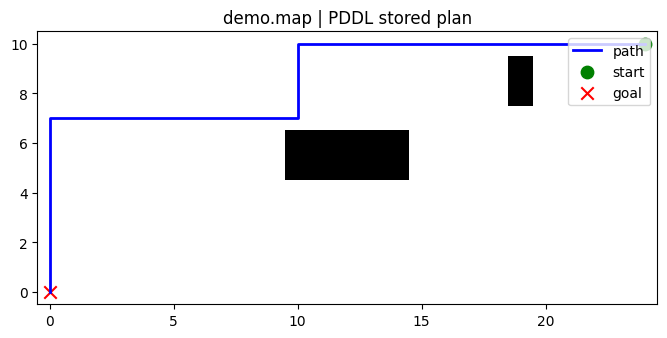

MAP: benchmarks/maps/local/dia10x10.map
Stored path length: 19
First steps: [(9, 9), (8, 9), (7, 9), (6, 9), (5, 9), (4, 9), (3, 9), (2, 9), (1, 9), (0, 9)]
Last steps: [(0, 9), (0, 8), (0, 7), (0, 6), (0, 5), (0, 4), (0, 3), (0, 2), (0, 1), (0, 0)]


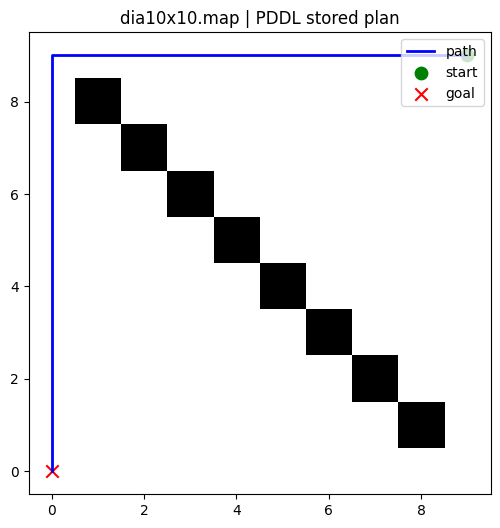

MAP: benchmarks/maps/local/adaptive-depth-1.map
Stored path length: 198
First steps: [(98, 98), (97, 98), (96, 98), (95, 98), (94, 98), (93, 98), (92, 98), (91, 98), (91, 97), (91, 96)]
Last steps: [(78, 24), (78, 25), (78, 26), (78, 27), (78, 28), (78, 29), (78, 30), (78, 31), (78, 32), (78, 33)]


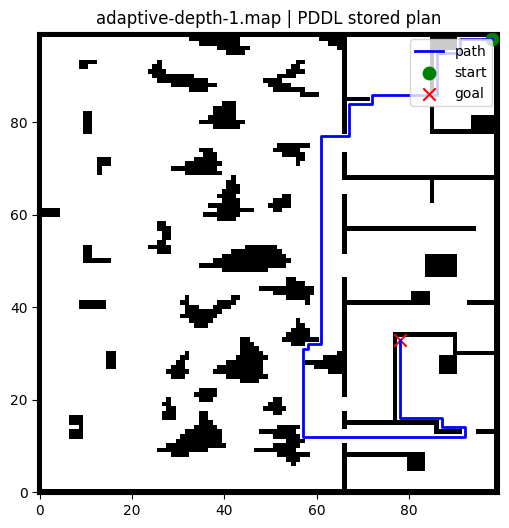

MAP: benchmarks/maps/gppc-2013/Aurora.map
Stored path length: 166
First steps: [(394, 76), (395, 75), (396, 75), (397, 75), (398, 75), (399, 75), (400, 75), (401, 75), (402, 75), (403, 75)]
Last steps: [(550, 0), (551, 1), (552, 1), (553, 2), (554, 2), (555, 2), (556, 3), (557, 4), (558, 5), (558, 6)]


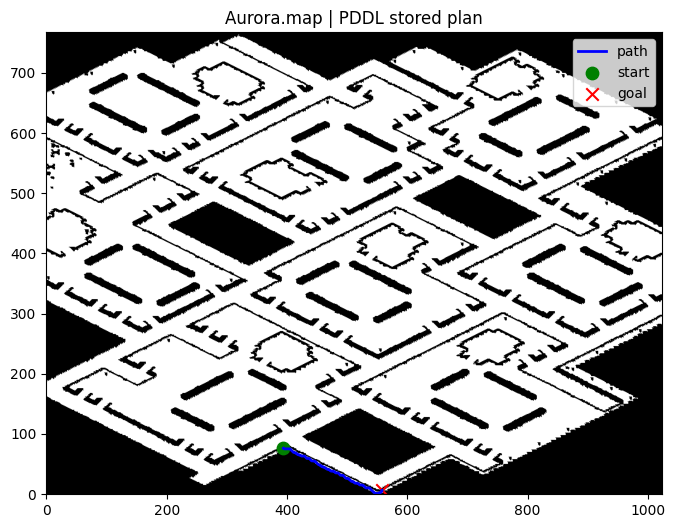

MAP: benchmarks/maps/gppc-2013/Brushfire.map
Stored path length: 750
First steps: [(491, 507), (490, 506), (489, 505), (488, 504), (487, 503), (486, 502), (485, 501), (484, 500), (483, 499), (482, 498)]
Last steps: [(103, 498), (104, 499), (105, 500), (106, 501), (107, 502), (108, 503), (109, 504), (110, 505), (111, 506), (112, 507)]


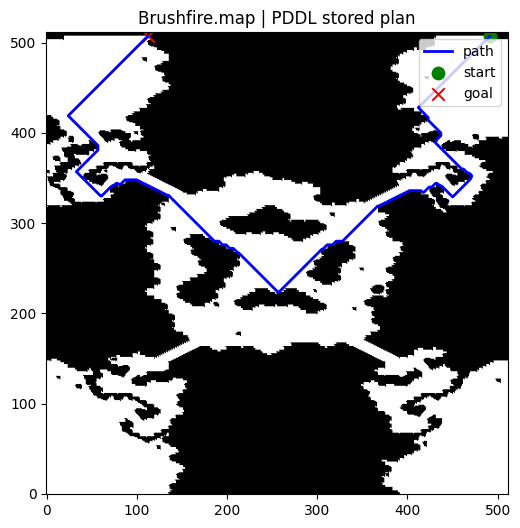

MAP: benchmarks/maps/gppc-2013/room-1100-110.map
Stored path length: 220
First steps: [(109, 219), (108, 218), (107, 217), (106, 216), (105, 215), (104, 214), (103, 213), (102, 212), (101, 211), (100, 210)]
Last steps: [(16, 9), (15, 8), (14, 7), (13, 6), (12, 5), (11, 4), (10, 3), (9, 2), (8, 1), (7, 0)]


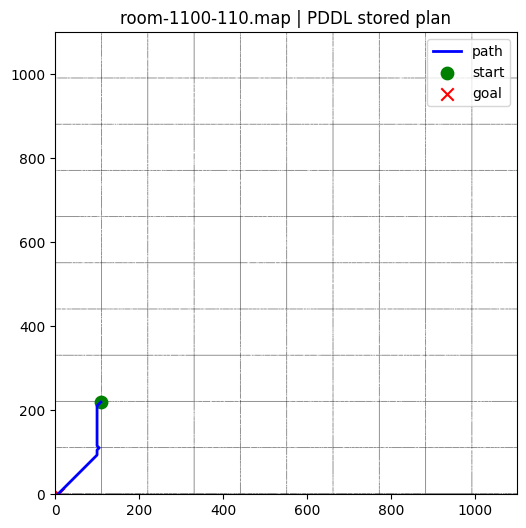

In [38]:
visualize_pddl_paths(df_pddl_easy, easy_maps, connectivity=4)
visualize_pddl_paths(df_pddl_hard, hard_maps, connectivity=8)

# Comparison between A* and PDDL


In [39]:
# A* AND PDDL RESULTS

# Unify PDDL tables (easy + hard)
df_pddl = pd.concat([df_pddl_easy, df_pddl_hard], ignore_index=True)

# Rename PDDL columns
df_pddl = df_pddl.rename(columns={
    "time_sec": "time_sec_pddl",
    "path_length": "path_length_pddl",
})

# Rename A* columns
df_astar = df_exp.rename(columns={
    "time_sec": "time_sec_astar",
    "path_length": "path_length_astar",
})

# Build comparison table
comparison_df = df_astar.merge(df_pddl, on=["map", "connectivity"], how="inner")
# Save CSV locally
comparison_df.to_csv("comparison_results.csv", index=False)

# Download CSV (Colab)
from google.colab import files
files.download("comparison_results.csv")

comparison_df



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,map,connectivity,heuristic,size,found_x,path_length_astar,time_sec_astar,expanded,generated,bf_min,...,max_explored,found_y,path_length_pddl,plan_steps,time_sec_pddl,pddl_expanded,pddl_generated,pddl_plan_length,pddl_plan_cost,pddl_path
0,demo.map,4,manhattan,25x11,True,35,0.00049,35,99,2,...,35,True,35,34,0.47005,262,955,34,34,"[(24, 10), (23, 10), (22, 10), (21, 10), (20, ..."
1,dia10x10.map,4,manhattan,10x10,True,19,0.00018,19,50,2,...,19,True,19,18,0.26230,81,253,18,18,"[(9, 9), (8, 9), (7, 9), (6, 9), (5, 9), (4, 9..."
2,adaptive-depth-1.map,4,manhattan,100x100,True,198,0.06744,5237,19626,1,...,5237,True,198,197,6.39547,8419,31807,197,197,"[(98, 98), (97, 98), (96, 98), (95, 98), (94, ..."
3,Aurora.map,8,euclidean,1024x768,True,166,0.00959,565,3296,2,...,565,True,166,165,232.29409,572,3335,165,165,"[(394, 76), (395, 75), (396, 75), (397, 75), (..."
4,Brushfire.map,8,euclidean,512x512,True,750,0.58875,48125,372984,1,...,48125,True,750,749,139.17248,104772,812327,749,749,"[(491, 507), (490, 506), (489, 505), (488, 504..."
5,room-1100-110.map,8,euclidean,1100x1100,True,220,0.16213,13572,107602,3,...,13572,True,220,219,675.79908,23790,187769,219,219,"[(109, 219), (108, 218), (107, 217), (106, 216..."


In [40]:
import matplotlib.pyplot as plt
import numpy as np

def plot_comparison_metrics(comparison_df):
    df = comparison_df.copy()

    # Clean invalid values
    df = df.dropna(subset=["time_sec_astar", "time_sec_pddl"])
    df = df[df["time_sec_astar"] > 0]

    maps = df["map"].tolist()
    x = np.arange(len(maps))


    # 1. Runtime Comparison (LOG SCALE)

    plt.figure(figsize=(14, 6))

    plt.bar(x - 0.2, df["time_sec_astar"], width=0.4,
            label="A*", color="steelblue", edgecolor="black")
    plt.bar(x + 0.2, df["time_sec_pddl"], width=0.4,
            label="PDDL", color="orange", edgecolor="black")

    plt.yscale("log")
    plt.xticks(x, maps, rotation=45, ha="right")
    plt.ylabel("Seconds (log scale)")
    plt.title("Runtime Comparison (A* vs PDDL)")
    plt.legend()
    plt.tight_layout()
    plt.show()


    # 2. Path Length Comparison

    plt.figure(figsize=(14, 6))

    plt.bar(x - 0.2, df["path_length_astar"], width=0.4,
            label="A*", color="steelblue", edgecolor="black")
    plt.bar(x + 0.2, df["path_length_pddl"], width=0.4,
            label="PDDL", color="orange", edgecolor="black")

    plt.xticks(x, maps, rotation=45, ha="right")
    plt.ylabel("Steps")
    plt.title("Path Length Comparison")
    plt.legend()
    plt.tight_layout()
    plt.show()


    # 3. Runtime Ratio (LOG SCALE + LABELS)

    df["speedup"] = df["time_sec_pddl"] / df["time_sec_astar"]

    plt.figure(figsize=(14, 6))

    bars = plt.bar(
        x, df["speedup"],
        color="mediumpurple",
        edgecolor="black",
        label="PDDL/A* Runtime Ratio"
    )

    # Log scale to avoid huge bars smashing the others
    plt.yscale("log")

    # Horizontal line at ratio 1
    plt.axhline(1.0, color="red", linestyle="--", linewidth=1.2, label="Equal runtime")

    plt.xticks(x, maps, rotation=45, ha="right")
    plt.ylabel("PDDL / A* (log scale)")
    plt.title("Runtime Ratio (PDDL slower if > 1)")
    plt.legend()

    # Add numeric labels only when useful (ratio > 3)
    for bar, value in zip(bars, df["speedup"]):
        if value > 3:
            plt.text(
                bar.get_x() + bar.get_width()/2,
                value,
                f"{value:.0f}x",
                ha="center",
                va="bottom",
                fontsize=10,
                rotation=90
            )

    plt.tight_layout()
    plt.show()

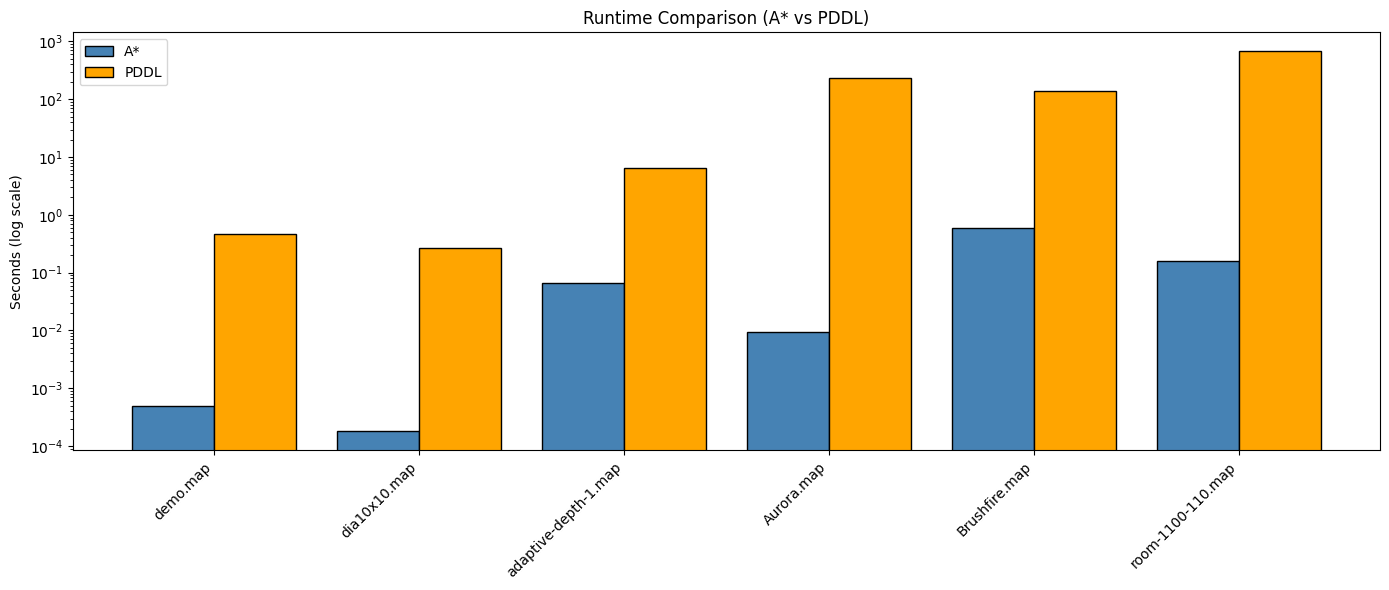

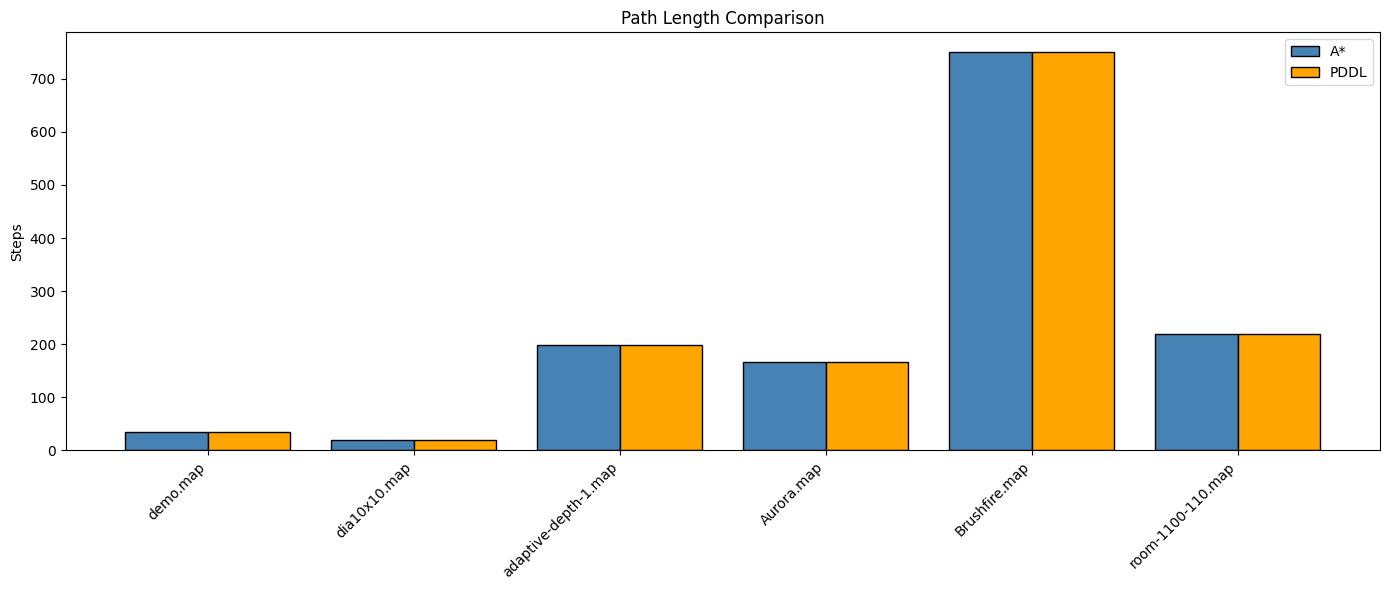

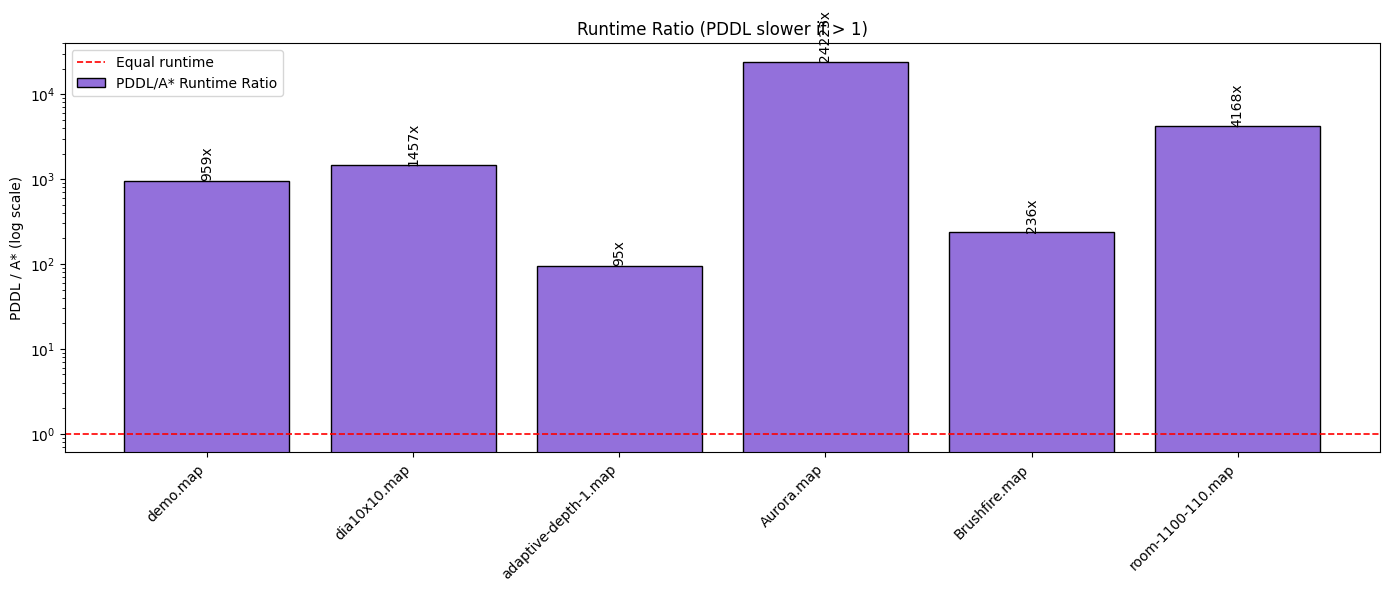

In [41]:
plot_comparison_metrics(comparison_df)